In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from skimage.io import imread, imshow
import math

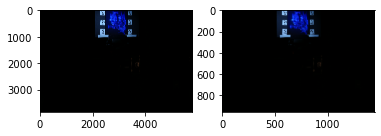

True

In [3]:
# downsample
image = cv2.imread("/home/jiwon/workspace/img_dataset/train_raw/images/6_4.jpg")
ratio = 4
height = image.shape[0] // ratio
width = image.shape[1] // ratio
resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR) # bilinear interpolation

f, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(resized)
plt.show()
cv2.imwrite("./example/downsampled.png", resized)

597 205
587 26
841 26
848 113
589 118
852 205
Detected Marker Centers: 6


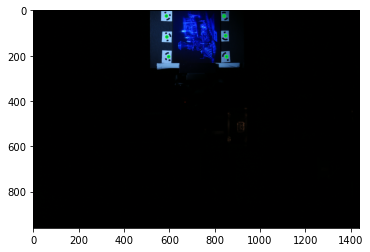

In [4]:
circled = image.copy()

maxRadius = int(1.1 * (width / 25) / 2) # hardcoded
minRadius = int(0.9 * (width / 35) / 2) # hardcoded

gray = cv2.cvtColor(circled, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(image=gray, 
                           method=cv2.HOUGH_GRADIENT, 
                           dp=1.2, 
                           minDist=2*minRadius,
                           param1=50,
                           param2=50,
                           minRadius=minRadius,
                           maxRadius=maxRadius                           
                          )

circled_resize = resized.copy()
origins = [[587, 26], [841, 26], [597, 205], [852, 205]]
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circlesRound = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circlesRound:
        x //= ratio
        y //= ratio
        r //= ratio
        cv2.circle(circled_resize, (x, y), r, (0, 255, 0), 4)
        cv2.circle(circled_resize, (x, y), radius=1, color=(0, 0, 255), thickness=2)
        print(x, y)
    
    print("Detected Marker Centers:", len(circlesRound))
    # cv2.imwrite("./circle_detected.png", circled_resize)
    plt.imshow(circled_resize)
    plt.show()

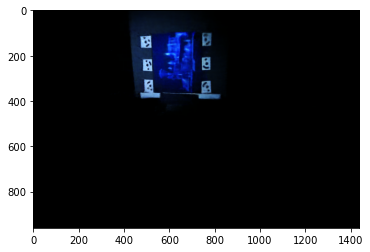

In [5]:
rendered_img = cv2.imread("./rendered/up_cam.png")
manual = rendered_img.copy()

manual_coord = [[495, 140], [760, 130], [503, 243], [765, 235], [515, 335], [765, 338]]
interest = [[495, 140], [760, 130], [515, 335], [765, 338]]
# for (x, y) in manual_coord:
#     cv2.circle(manual, (x, y), radius=1, color=(0, 0, 255), thickness=2)
# cv2.imwrite("./manual.png", manual)
plt.imshow(manual)
plt.show()

<Figure size 640x480 with 0 Axes>

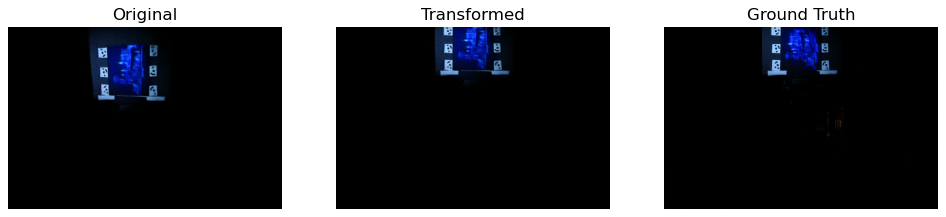

In [6]:
# homography
# reference: https://learnopencv.com/homography-examples-using-opencv-python-c/
rendered_img = cv2.imread("./rendered/up_cam.png")
manual = rendered_img.copy()
image = cv2.imread("./example/downsampled.png")
resized = image.copy()

points_of_interest = np.array(interest)
projection = np.array(origins)
h, status = cv2.findHomography(points_of_interest, projection)
im_dst = cv2.warpPerspective(manual, h, (resized.shape[1], resized.shape[0]))
cv2.imwrite("./example/tf_img_warp.png", im_dst) 

plt.figure(num=None, figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(1,3, figsize=(15, 10), dpi = 80)
ax[0].set_title(f'Original', fontsize = 15)
ax[0].imshow(rendered_img)
ax[0].set_axis_off()
ax[1].set_title(f'Transformed', fontsize = 15)
ax[1].imshow(im_dst)
ax[1].set_axis_off()
ax[2].set_title(f'Ground Truth', fontsize = 15)
ax[2].imshow(resized)
ax[2].set_axis_off()


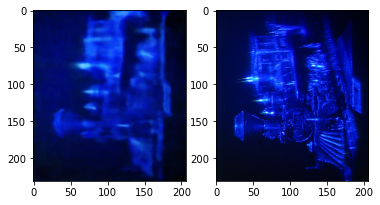

In [7]:
# crop inner-marker area
registered = cv2.imread("./example/tf_img_warp.png")
ground_truth = cv2.imread("./example/downsampled.png")
panel_area = [[615, 0], [820, 0], [615, 230], [820, 230]] # hardcoded
# for (x, y) in panel_area:
#     cv2.circle(registered, (x, y), radius=1, color=(0, 0, 255), thickness=2)

# img crop reference: https://stackoverflow.com/a/54885575
homography_crop = registered[0 : 230 + 1, 615 : 820 + 1]
downsampled_crop = ground_truth[0 : 230 + 1, 615 : 820 + 1]
f, ax = plt.subplots(1,2)
ax[0].imshow(homography_crop)
ax[1].imshow(downsampled_crop)

In [8]:
# psnr
# reference: https://dsp.stackexchange.com/a/50704
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnr_val = psnr(downsampled_crop, homography_crop)
print("PSNR Value:", psnr_val)

PSNR Value: 30.248528943415764


In [12]:
# gain calculation: (ImgA - ImgB) * gain + 0.5
# convert 0-255 uint8 into 0-1 scale
truth_norm = cv2.normalize(downsampled_crop, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
pred_norm = cv2.normalize(homography_crop, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
subtracted = truth_norm - pred_norm
gain = 5
cv2.imwrite("./example/gain_350.png", subtracted * 350 + 0.5)

# plt.figure(num=None, figsize=(8, 6), dpi=80)
# fig, ax = plt.subplots(1,3, figsize=(15, 10), dpi = 80)
# ax[0].set_title(f'gain=1', fontsize = 15)
# ax[0].imshow(subtracted * 1 + 0.5, cmap='gray')
# ax[0].set_axis_off()
# ax[1].set_title(f'gain=5', fontsize = 15)
# ax[1].imshow(subtracted * 5 + 0.5, cmap='gray')
# ax[1].set_axis_off()
# ax[2].set_title(f'gain=10', fontsize = 15)
# ax[2].imshow(subtracted * 10 + 0.5, cmap='gray')
# ax[2].set_axis_off()

True